In [2]:
import yfinance as yf
import pandas as pd

In [3]:
def get_historical_data(ticker):
  d = yf.Ticker(ticker)
  df = d.history(period="max")
  df.columns = df.columns.str.lower()
  df.columns = pd.Series(df.columns).str.capitalize().values
  return df.dropna()

In [4]:
df = get_historical_data('BA')
df

,Open,High,Low,Close,Volume,Dividends,Stock splits
Date,,,,,,,
1962-01-02,0.190310,0.190310,0.187037,0.187037,352200,0.0,0.0
1962-01-03,0.189843,0.193584,0.189843,0.190778,710400,0.0,0.0
1962-01-04,0.190778,0.194051,0.188908,0.188908,911000,0.0,0.0
1962-01-05,0.188908,0.189843,0.180023,0.185167,880400,0.0,0.0
1962-01-08,0.185167,0.188440,0.182829,0.185635,473600,0.0,0.0
...,...,...,...,...,...,...,...
2020-11-16,194.559998,202.940002,191.350006,202.399994,40562800,0.0,0.0
2020-11-17,200.250000,211.199997,196.050003,210.050003,38299300,0.0,0.0
2020-11-18,223.020004,223.020004,203.000000,203.300003,65990700,0.0,0.0


In [5]:
import talib

# compute simple moving average using talib
sma1 = talib.SMA(df.Close, timeperiod=20)
sma2 = talib.SMA(df.Close, timeperiod=60)

# compute buy and sell signals (golden cross and death cross)
signal_long = (sma1 > sma2) & (sma1.shift() < sma2.shift())
signal_short = (sma1 < sma2) & (sma1.shift() > sma2.shift())

# combine long and short signals
signal = signal_long.copy()
signal[signal_short] = -1

<AxesSubplot:label='33f291b8-7440-4cdf-bf9c-d23084191e2d'>

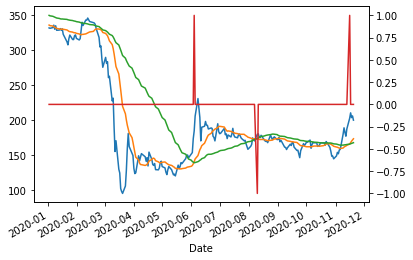

In [6]:
df.Close['2020'].plot()
sma1['2020'].plot()
sma2['2020'].plot()
signal['2020'].astype(int).plot(secondary_y=True)

In [7]:
from backtesting import Backtest, Strategy

class Strategy(Strategy):
    
    n1 = 20
    n2 = 60
    
    def init(self):
        super().init()
        
        # Precompute the two moving averages
        close = pd.Series(self.data.Close)
        sma1 = talib.SMA(close, timeperiod=self.n1)
        sma2 = talib.SMA(close, timeperiod=self.n2)

        # Precompute signal
        signal_long = (sma1 > sma2) & (sma1.shift() < sma2.shift())
        signal_short = (sma1 < sma2) & (sma1.shift() > sma2.shift())

        # combine signal
        signal = signal_long
        signal[signal_short] = -1
        
        # plot sma
        self.I(lambda x: sma1, 'sma1')
        self.I(lambda x: sma2, 'sma2')

        # set signal to trade
        self.signal = self.I(lambda x: signal, 'signal')

    def next(self):
        super().next()

        entry_size = self.signal[-1]

        if entry_size > 0:
            self.buy()
        elif entry_size < 0:
          for trade in self.trades:
              trade.close()

bt = Backtest(df, Strategy)
result1 = bt.run()
bt.plot()

/Users/panyuehsheng/opt/anaconda3/envs/quant/lib/python3.8/site-packages/backtesting/_plotting.py:45: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

/Users/panyuehsheng/opt/anaconda3/envs/quant/lib/python3.8/site-packages/backtesting/_plotting.py:104: UserWarning: Data contains too many candlesticks to plot; downsampling to '1W'. See `Backtest.plot(resample=...)`
  warnings.warn("Data contains too many candlesticks to plot; downsampling to {!r}. "


In [8]:
result2 = bt.optimize(n1=range(5, 200, 10),
                      n2=range(5, 200, 10))
result2._strategy

<ipython-input-8-dea20e7a91a8>:1: UserWarning: Searching for best of 400 configurations.
  result2 = bt.optimize(n1=range(5, 200, 10),
/Users/panyuehsheng/opt/anaconda3/envs/quant/lib/python3.8/site-packages/backtesting/backtesting.py:1295: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


<Strategy Strategy(n1=35,n2=45)>

<AxesSubplot:xlabel='Date'>

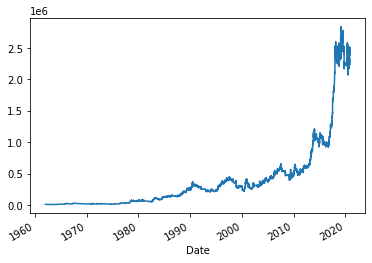

In [9]:
((result1._equity_curve.Equity + 
result2._equity_curve.Equity)/2).plot()